# ATML2021 Assignment 3 Nalet Meinen

In [1]:
import os
import numpy as np
from torch.utils.data import Dataset, DataLoader, Subset, random_split
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision
import torchvision.transforms.functional as TF
import time
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import PIL.Image as Image
import pandas as pd
import random

import torchvision.utils as vutils

In [2]:
!nvidia-smi

Tue May 25 09:49:06 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.118.02   Driver Version: 440.118.02   CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:03:00.0 Off |                  N/A |
| 29%   55C    P2    67W / 250W |   1314MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:04:00.0 Off |                  N/A |
| 79%   82C    P0    78W / 250W |     10MiB / 11175MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

# Soft Baseline

Here we implement the dataset class, create the training, validation and test sets and the dataloaders.

In [3]:
class LabeledDataset(Dataset):
    def __init__(self, folder_path, phase='train', transform=None):
        super(LabeledDataset, self).__init__()
        self.phase = phase
        if self.phase == 'train':
            file_path = os.path.join(folder_path, 'train_32x32_500_label.npz')
        elif self.phase == 'val':
            file_path = os.path.join(folder_path, 'test_32x32_2000_label.npz')
        elif self.phase == 'test':
            file_path = os.path.join(folder_path, 'test_32x32_competition.npy')
        elif self.phase == 'unlabel':
            file_path = os.path.join(folder_path, 'train_32x32_unlabel.npy')
        else:
            print('Unrecognized phase')
        data_load = np.load(file_path)
        
        if self.phase != 'test' and self.phase != 'unlabel':
            self.dataset = data_load['img']
            self.labels = data_load['label'].astype('int64')
        else:
            self.dataset = data_load
            
        self.transform = transform
        
    def __getitem__(self, index): 
        img_index = Image.fromarray(self.dataset[index,:])
        if self.phase != 'test' and self.phase != 'unlabel':
            return self.transform(img_index), self.labels[index,0]
        else:
            return self.transform(img_index)

    def __len__(self):
        return self.dataset.shape[0]

In [4]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

transform=transforms.Compose([ transforms.ToTensor(),
                               transforms.Normalize((0.4380, 0.4440, 0.4730), (0.1751, 0.1771, 0.1744))
                             ])

transform_train=transforms.Compose([ transforms.RandomChoice([
                                         transforms.RandomResizedCrop(32,scale=(0.85, 1.0), ratio=(0.9, 1.1)),
                                         transforms.RandomRotation([-7,7]),
                                         torchvision.transforms.ColorJitter()
                                     ]),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.4380, 0.4440, 0.4730), (0.1751, 0.1771, 0.1744))
                             ])

train_set = LabeledDataset('.', phase='train', transform=transform_train)
val_set = LabeledDataset('.', phase='val', transform=transform)
test_set = LabeledDataset('.', phase='test', transform=transform)
unlabel_set = LabeledDataset('.', phase='unlabel', transform=transform_train)

batch_size = 64
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=4)
unlabel_loader = DataLoader(unlabel_set, batch_size=batch_size, shuffle=True, num_workers=4)


#Here we concat the dataset multiple time to have more images (augumentation)
train_set_2 = LabeledDataset('.', phase='train', transform=transform_train)

for _ in range(7):
    train_set_2 = torch.utils.data.ConcatDataset([train_set_2, train_set_2])

train_loader_2 = DataLoader(train_set_2, batch_size=batch_size, shuffle=True, num_workers=4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: 7
Image shape: torch.Size([3, 32, 32])


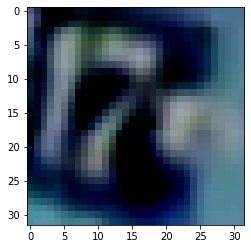

In [5]:
sample_image = train_set[0]
plt.imshow(sample_image[0].permute(1,2,0)*0.5 + 0.5)
print("Label:", sample_image[1])
print("Image shape:", sample_image[0].shape)

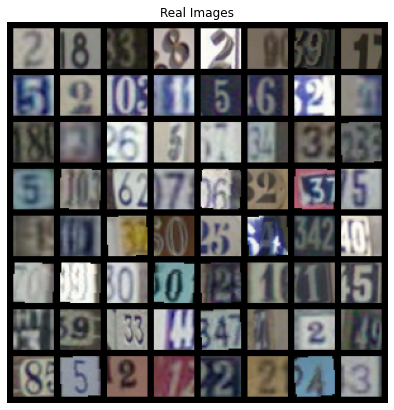

In [6]:
real_batch = next(iter(unlabel_loader))

plt.figure(figsize=(7,7))
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch.to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

Let us define a fully-convolutional classifier.

In [7]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(128, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),

            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 32, 4, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(True),

            nn.ConvTranspose2d(32, 3, 4, 1, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

class Discriminator(nn.Module):
    def __init__(self, num_classes=10):
        super(Discriminator, self).__init__()
        self.layer01 = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.layer02 = nn.Sequential(
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.layer03 = nn.Sequential(
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        
        self.layer04 = nn.Sequential(
            nn.Conv2d(256, 1024, 4, 2, 1),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True)
        )
        self.layer05 = nn.Sequential(
            nn.Conv2d(1024, 1, 2, 1, 0, bias=False),
            nn.Sigmoid()
        )
        
    def forward(self, img):
        output = self.layer01(img)
        output = self.layer02(output)
        output = self.layer03(output)
        output = self.layer04(output)
        output = self.layer05(output)
        return output.squeeze(3).squeeze(2)

class ClassifierNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ClassifierNet, self).__init__()
        self.layer01 = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.layer02 = nn.Sequential(
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.layer03 = nn.Sequential(
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        
        self.layer04 = nn.Sequential(
            nn.Conv2d(256, 1024, 4, 2, 1),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True)
        )
        
        self.layer05 = nn.Sequential(
            nn.Conv2d(1024, 512, 2, 2, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self.classification_head = nn.Sequential(
            nn.Conv2d(512, num_classes, 2, 1, 0),
        )
        
    def forward(self, img):
        output = self.layer01(img)
        output = self.layer02(output)
        output = self.layer03(output)
        output = self.layer04(output)
        output = self.layer05(output)
        output = self.classification_head(output)
        return output.squeeze(3).squeeze(2)
    
print(Generator())
print(Discriminator())
print(ClassifierNet())

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(128, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(32, 3, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [8]:
model = ClassifierNet().to(device)

noise = torch.randn(4, 3, 32, 32, device=device)
out = model(noise)
print("Model output shape:", out.size())

Model output shape: torch.Size([4, 10])


Define the criterion and the optimizer.

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),  lr=0.001)

Train the model for 20 epochs.

In [10]:
for epoch in tqdm(range(30)):

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 10 == 9:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, loss.item()))
            running_loss = 0.0

  0%|          | 0/30 [00:00<?, ?it/s]

Test the model on the validation set.

In [11]:
correct = 0
total = 0
total_loss = 0
with torch.no_grad():
    for data in val_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
            
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        total_loss += loss.item()

print('Accuracy of the network on the 2000 validation images: %d %%' % (
    100 * correct / total))
print('Val loss', total_loss / len(val_loader))

Accuracy of the network on the 2000 validation images: 58 %
Val loss 2.031244818121195


In [12]:
# Number of training epochs
num_epochs = 20

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

netG = Generator().to(device)
netD = Discriminator().to(device)

criterion = nn.BCELoss()

fixed_noise = torch.randn(64, 128, 1, 1, device=device)

real_label = 1
fake_label = 0

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

img_list = []
G_losses = []
D_losses = []
iters = 0

pbar = tqdm(range(num_epochs))
for epoch in pbar:
    for i, data in enumerate(unlabel_loader):
        # maximize log(D(x)) + log(1 - D(G(z)))
        netD.zero_grad()
        real_cpu = data.to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, 128, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        # maximize log(D(G(z)))
        netG.zero_grad()
        label.fill_(real_label) 
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        pbar.set_description('[%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                            % (i, len(unlabel_loader), errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
    
        iters += 1

    with torch.no_grad():
        fake = netG(fixed_noise).detach().cpu()
        img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
        
torch.save(netD.state_dict(), "unsuperviced_pre-training.pht")

  0%|          | 0/10 [00:00<?, ?it/s]

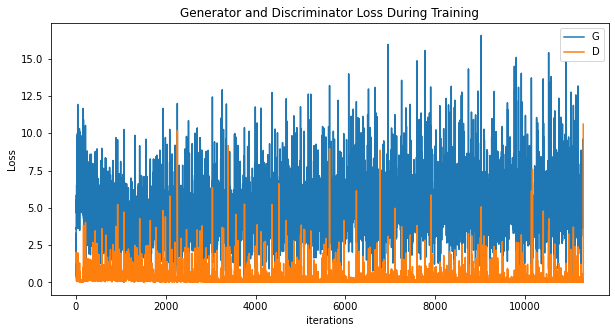

In [13]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

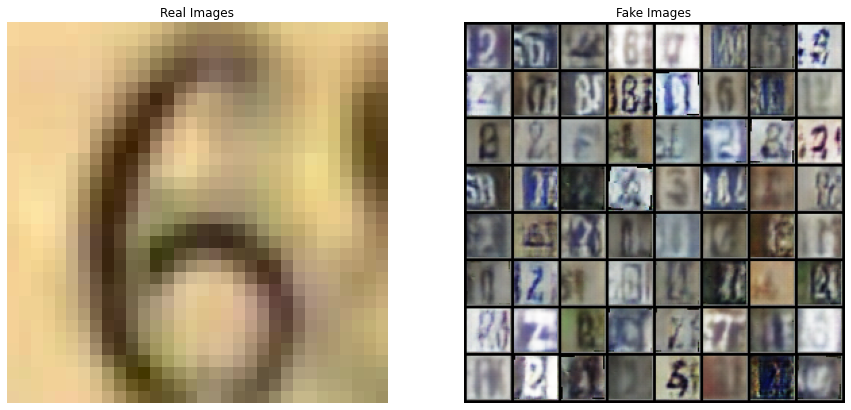

In [14]:
real_batch = next(iter(unlabel_loader))

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch.to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

In [15]:
def train(model, train_loader, optimizer, loss_fn):
    '''
    Trains the model for one epoch
    '''
    model.train()
    losses = []
    n_correct = 0
    for iteration, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        output = model(images)
        optimizer.zero_grad()
        loss = loss_fn(output, labels)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        n_correct += torch.sum(output.argmax(1) == labels).item()
    accuracy = 100.0 * n_correct / len(train_loader.dataset)
    return np.mean(np.array(losses)), accuracy
            
def test(model, test_loader, loss_fn):
    '''
    Tests the model on data from test_loader
    '''
    model.eval()
    test_loss = 0
    n_correct = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            output = model(images)
            loss = loss_fn(output, labels)
            test_loss += loss.item()
            n_correct += torch.sum(output.argmax(1) == labels).item()

    average_loss = test_loss / len(test_loader)
    accuracy = 100.0 * n_correct / len(test_loader.dataset)
    return average_loss, accuracy


def fit(taskname,train_dataloader, val_dataloader, model, optimizer, loss_fn, n_epochs, num_classes=10):

    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []

    last_val_accuracies = 0
    best_epoch = 1

    for epoch in range(n_epochs):
        train_loss, train_accuracy = train(model, train_dataloader, optimizer, loss_fn)
        val_loss, val_accuracy = test(model, val_dataloader, loss_fn)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print("""Epoch {}/{}: train_loss: {:.4f}, train_accuracy: {:.4f}, val_loss: {:.4f}, val_accuracy: {:.4f}""".format(
                        epoch+1, n_epochs, train_losses[-1], train_accuracies[-1], val_losses[-1], val_accuracies[-1]))

        if val_accuracies[-1] > last_val_accuracies:
            torch.save(model.state_dict(), str(taskname)+".pht")
            best_epoch = epoch+1
            last_val_accuracies = val_accuracies[-1]

    best_model = ClassifierNet(num_classes=num_classes)
    best_model = best_model.to(device)
    best_model.load_state_dict(torch.load(str(taskname)+".pht"))

    return train_losses, train_accuracies, val_losses, val_accuracies, loss_fn, best_model, best_epoch

def plot_results(train_results, test_dataloader, val_dataloader):
    train_losses, train_accuracies, val_losses, val_accuracies, loss_fn, best_model, best_epoch = train_results

    fig, axs = plt.subplots(1, 2, figsize=(15, 4))

    axs[0].plot(np.arange(len(train_losses)), train_losses)
    axs[0].plot(np.arange(len(val_losses)), val_losses)
    axs[0].legend(['train_loss', 'val_loss'])
    axs[0].set_xlabel('epoch')
    axs[0].set_ylabel('loss value')
    axs[0].set_title('Train/val loss')

    axs[1].plot(np.arange(len(train_accuracies)), train_accuracies)
    axs[1].plot(np.arange(len(val_accuracies)), val_accuracies)
    axs[1].legend(['train_acc', 'val_acc'])
    axs[1].set_xlabel('epoch')
    axs[1].set_ylabel('accuracy')
    axs[1].set_title('Train/val accuracy')

    plt.show()

    m_loss, accuracy = test(best_model, val_dataloader, loss_fn)
    print("Best Epoch:", best_epoch, "Average loss:", m_loss, "Accuracy:", accuracy)
    torch.cuda.empty_cache()

def test_pretrained(taskname,num_blocks,val_dataloader,loss_fn):
    best_model = ClassifierNet(num_blocks)
    best_model = best_model.to(device)
    best_model.load_state_dict(torch.load(str(taskname)+".pht"))
    m_loss, accuracy = test(best_model, val_dataloader, loss_fn)
    print("Model:", taskname, "Average loss:", m_loss, "Accuracy:", accuracy)

def show_validation_errors(taskname,num_blocks,test_loader,num_images=10):
    model = ClassifierNet(num_blocks)
    model = model.to(device)
    model.load_state_dict(torch.load(str(taskname)+".pht"))

    model.eval()
    images_so_far = 0
    fig = plt.figure()

    def imshow(inp, title=None):
        """Imshow for Tensor."""
        inp = inp.numpy().transpose((1, 2, 0))
        mean = np.array(_t_mean)
        std = np.array(_t_std)
        inp = std * inp + mean
        inp = np.clip(inp, 0, 1)
        plt.figure(figsize=(5,5))
        plt.imshow(inp)
        if title is not None:
            plt.title(title)
        plt.pause(0.001)

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            output = model(images)
            _, preds = torch.max(output, 1)
            
            for j in range(images.size()[0]):
                if(labels.cpu().data[j] == preds[j]):
                    continue
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('actual: {}, predicted: {}'.format(labels.cpu().data[j], preds[j]))
                imshow(images.cpu().data[j])

                if images_so_far == num_images:
                    return

    average_loss = test_loss / len(test_loader)
    accuracy = 100.0 * n_correct / len(test_loader.dataset)
    return average_loss, accuracy

In [31]:
def get_transfer_model(net="GAN"): 
    if net == "GAN" or net == "TransRotPre":
        #Preparations
        pretrained_model = Discriminator()
        pretrained_model = pretrained_model.to(device)
        pretrained_model.load_state_dict(torch.load("unsuperviced_pre-training.pht"))
    if net == "RotPre":
        #Preparations
        pretrained_model = ClassifierNet(num_classes=4)
        pretrained_model = pretrained_model.to(device)
        pretrained_model.load_state_dict(torch.load("rotation_prediction.pht"))

    #Transfer
    transfer_model = ClassifierNet()
    if net == "TransRotPre":
        transfer_model = ClassifierNet(num_classes=4)
    transfer_model.layer01 = pretrained_model.layer01
    transfer_model.layer02 = pretrained_model.layer02
    transfer_model.layer03 = pretrained_model.layer03
    transfer_model.layer04 = pretrained_model.layer04
    return transfer_model

In [17]:
n_epochs = 50
lr = 0.0001
loss_fn = nn.CrossEntropyLoss()

Epoch 1/50: train_loss: 0.0969, train_accuracy: 97.5359, val_loss: 1.2972, val_accuracy: 65.4500
Epoch 2/50: train_loss: 0.0063, train_accuracy: 99.8734, val_loss: 1.5326, val_accuracy: 63.8000
Epoch 3/50: train_loss: 0.0004, train_accuracy: 99.9984, val_loss: 1.4095, val_accuracy: 67.0000
Epoch 4/50: train_loss: 0.0057, train_accuracy: 99.8719, val_loss: 1.7240, val_accuracy: 62.6500
Epoch 5/50: train_loss: 0.0035, train_accuracy: 99.9219, val_loss: 1.5750, val_accuracy: 67.0500
Epoch 6/50: train_loss: 0.0022, train_accuracy: 99.9391, val_loss: 1.7494, val_accuracy: 66.7500
Epoch 7/50: train_loss: 0.0003, train_accuracy: 99.9922, val_loss: 1.7342, val_accuracy: 68.4000
Epoch 8/50: train_loss: 0.0039, train_accuracy: 99.8984, val_loss: 1.6029, val_accuracy: 67.8500
Epoch 9/50: train_loss: 0.0005, train_accuracy: 99.9906, val_loss: 1.6633, val_accuracy: 69.3000
Epoch 10/50: train_loss: 0.0020, train_accuracy: 99.9359, val_loss: 1.9062, val_accuracy: 67.4500
Epoch 11/50: train_loss: 0.00

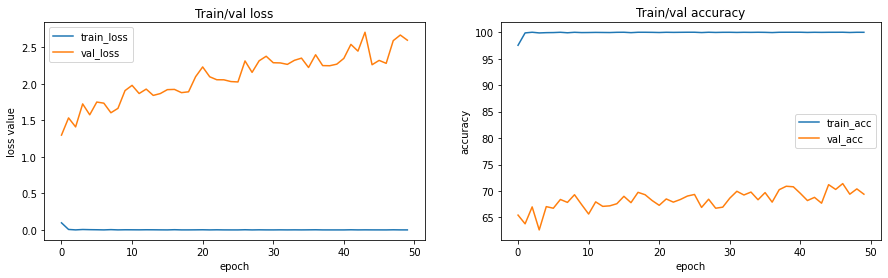

Best Epoch: 47 Average loss: 2.2790833227336407 Accuracy: 71.4
CPU times: user 9min 35s, sys: 1min 27s, total: 11min 3s
Wall time: 11min 5s


In [18]:
%%time
model = ClassifierNet()
model = model.to(device)
model.load_state_dict(get_transfer_model().state_dict())

model.layer01.requires_grad = False
model.layer02.requires_grad = False
model.layer03.requires_grad = False
model.layer04.requires_grad = False

optimizer = optim.Adam(model.parameters(), lr=lr, betas=(beta1, 0.999))

fixed_features_results = fit("fixed_features", train_loader_2, val_loader, model, optimizer, loss_fn, n_epochs)
plot_results(fixed_features_results, train_loader_2, val_loader)

Epoch 1/50: train_loss: 0.0951, train_accuracy: 97.6141, val_loss: 1.3269, val_accuracy: 66.0500
Epoch 2/50: train_loss: 0.0022, train_accuracy: 99.9688, val_loss: 1.4329, val_accuracy: 65.3500
Epoch 3/50: train_loss: 0.0044, train_accuracy: 99.8875, val_loss: 1.5313, val_accuracy: 66.3000
Epoch 4/50: train_loss: 0.0003, train_accuracy: 99.9984, val_loss: 1.5104, val_accuracy: 68.5000
Epoch 5/50: train_loss: 0.0054, train_accuracy: 99.8422, val_loss: 1.5564, val_accuracy: 66.9000
Epoch 6/50: train_loss: 0.0007, train_accuracy: 99.9859, val_loss: 1.6715, val_accuracy: 67.4500
Epoch 7/50: train_loss: 0.0023, train_accuracy: 99.9375, val_loss: 1.7977, val_accuracy: 66.2500
Epoch 8/50: train_loss: 0.0017, train_accuracy: 99.9656, val_loss: 1.6241, val_accuracy: 69.0000
Epoch 9/50: train_loss: 0.0030, train_accuracy: 99.9000, val_loss: 1.7714, val_accuracy: 66.8000
Epoch 10/50: train_loss: 0.0016, train_accuracy: 99.9500, val_loss: 1.8368, val_accuracy: 67.7000
Epoch 11/50: train_loss: 0.00

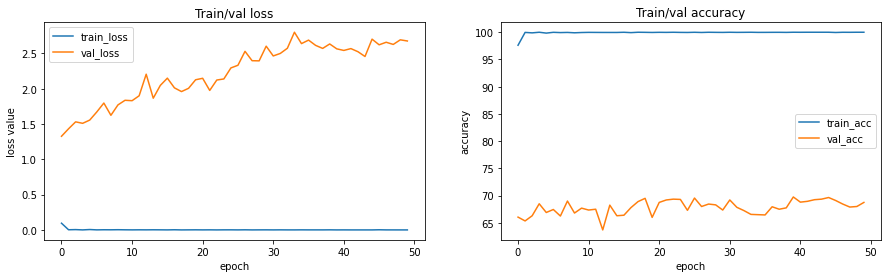

Best Epoch: 40 Average loss: 2.5656269900500774 Accuracy: 69.75
CPU times: user 9min 19s, sys: 1min 28s, total: 10min 48s
Wall time: 10min 53s


In [19]:
%%time
#Preparations
model = ClassifierNet()
model = model.to(device)
model.load_state_dict(get_transfer_model().state_dict())

optimizer = optim.Adam(model.parameters(), lr=lr, betas=(beta1, 0.999))

fixed_features_results = fit("finetuned_features", train_loader_2, val_loader, model, optimizer, loss_fn, n_epochs)
plot_results(fixed_features_results, train_loader_2, val_loader)

# Hard Baseline

In [20]:
class RotationDataset(Dataset):
    def __init__(self, folder_path, phase='unlabel', transform=None):
        super(RotationDataset, self).__init__()
        self.phase = phase
        if self.phase == 'unlabel':
            file_path = os.path.join(folder_path, 'train_32x32_unlabel.npy')
        else:
            print('Unrecognized phase')
        data_load = np.load(file_path)
        
        self.dataset = data_load
            
        self.transform = transform
        
    def __getitem__(self, index): 
        img_index = Image.fromarray(self.dataset[index,:])
        
        _rand_index = np.random.choice(4, 1)[0]
        _angles = np.array([0, 90, 180, 270])
        
        _img = img_index.rotate(_angles[_rand_index])
        _img = self.transform(_img)
        
        return _img, _rand_index

    def __len__(self):
        return self.dataset.shape[0]

In [21]:
rotation_set = RotationDataset('.', phase='unlabel', transform=transform_train)
train_rotation_set, val_rotation_set = torch.utils.data.random_split(rotation_set, [int(len(rotation_set) * 0.9), len(rotation_set) - int((len(rotation_set) * 0.9))])

train_rotation_loader = DataLoader(train_rotation_set, batch_size=batch_size, shuffle=True, num_workers=4)
val_rotation_loader = DataLoader(val_rotation_set, batch_size=batch_size, shuffle=True, num_workers=4)

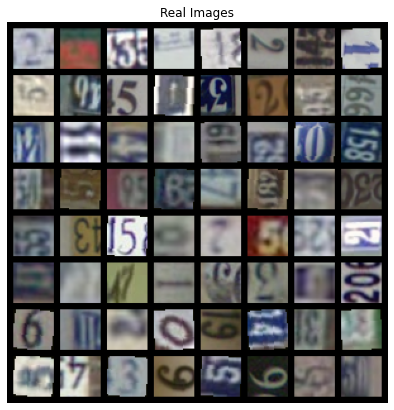

In [22]:
real_batch = next(iter(train_rotation_loader))

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

Epoch 1/30: train_loss: 0.5765, train_accuracy: 72.5085, val_loss: 0.6018, val_accuracy: 71.4642
Epoch 2/30: train_loss: 0.4572, train_accuracy: 79.1100, val_loss: 0.4421, val_accuracy: 79.6430
Epoch 3/30: train_loss: 0.4064, train_accuracy: 81.9240, val_loss: 0.4214, val_accuracy: 80.5702
Epoch 4/30: train_loss: 0.3736, train_accuracy: 83.4464, val_loss: 0.3730, val_accuracy: 83.5040
Epoch 5/30: train_loss: 0.3470, train_accuracy: 84.7611, val_loss: 0.3917, val_accuracy: 82.6322
Epoch 6/30: train_loss: 0.3268, train_accuracy: 85.9898, val_loss: 0.3515, val_accuracy: 84.3343
Epoch 7/30: train_loss: 0.3082, train_accuracy: 86.7094, val_loss: 0.3335, val_accuracy: 84.7495
Epoch 8/30: train_loss: 0.2960, train_accuracy: 87.3061, val_loss: 0.3392, val_accuracy: 84.7357
Epoch 9/30: train_loss: 0.2814, train_accuracy: 88.1656, val_loss: 0.3326, val_accuracy: 85.2754
Epoch 10/30: train_loss: 0.2676, train_accuracy: 88.7515, val_loss: 0.3068, val_accuracy: 86.6593
Epoch 11/30: train_loss: 0.25

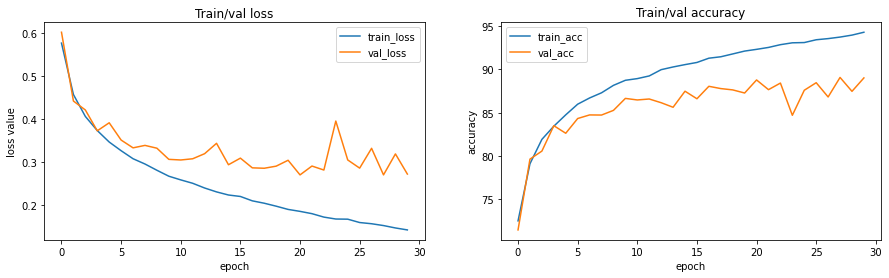

Best Epoch: 28 Average loss: 0.28613901810835946 Accuracy: 88.62441184611126
CPU times: user 5min 40s, sys: 53.4 s, total: 6min 33s
Wall time: 6min 40s


In [32]:
%%time
n_epochs = 30
lr = 0.0001
loss_fn = nn.CrossEntropyLoss()

#Preparations
model = ClassifierNet(num_classes=4)
model = model.to(device)
model.load_state_dict(get_transfer_model(net="TransRotPre").state_dict())

optimizer = optim.Adam(model.parameters(), lr=lr, betas=(beta1, 0.999))

rotation_prediction_results = fit("rotation_prediction", train_rotation_loader, val_rotation_loader, model, optimizer, loss_fn, n_epochs, num_classes=4)
plot_results(rotation_prediction_results, train_rotation_loader, val_rotation_loader)

In [33]:
n_epochs = 10
lr = 0.0001
loss_fn = nn.CrossEntropyLoss()

Epoch 1/10: train_loss: 0.0411, train_accuracy: 99.2438, val_loss: 0.6788, val_accuracy: 79.4000
Epoch 2/10: train_loss: 0.0016, train_accuracy: 99.9766, val_loss: 0.7654, val_accuracy: 78.9500
Epoch 3/10: train_loss: 0.0001, train_accuracy: 100.0000, val_loss: 0.7815, val_accuracy: 79.0000
Epoch 4/10: train_loss: 0.0046, train_accuracy: 99.8828, val_loss: 0.9119, val_accuracy: 77.8000
Epoch 5/10: train_loss: 0.0002, train_accuracy: 99.9984, val_loss: 0.9904, val_accuracy: 76.9500
Epoch 6/10: train_loss: 0.0001, train_accuracy: 100.0000, val_loss: 0.9695, val_accuracy: 77.3000
Epoch 7/10: train_loss: 0.0000, train_accuracy: 100.0000, val_loss: 0.9632, val_accuracy: 77.7000
Epoch 8/10: train_loss: 0.0000, train_accuracy: 100.0000, val_loss: 0.9692, val_accuracy: 77.9000
Epoch 9/10: train_loss: 0.0000, train_accuracy: 100.0000, val_loss: 0.9772, val_accuracy: 77.8000
Epoch 10/10: train_loss: 0.0037, train_accuracy: 99.9062, val_loss: 1.1597, val_accuracy: 74.7500


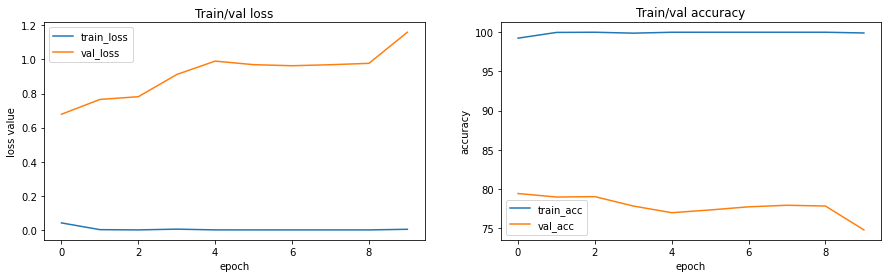

Best Epoch: 1 Average loss: 0.6787505894899368 Accuracy: 79.4
CPU times: user 1min 50s, sys: 17.4 s, total: 2min 7s
Wall time: 2min 8s


In [34]:
%%time
model = ClassifierNet()
model = model.to(device)
model.load_state_dict(get_transfer_model(net="RotPre").state_dict())

model.layer01.requires_grad = False
model.layer02.requires_grad = False
model.layer03.requires_grad = False
model.layer04.requires_grad = False

optimizer = optim.Adam(model.parameters(), lr=lr, betas=(beta1, 0.999))

fixed_features_results = fit("fixed_features_rot", train_loader_2, val_loader, model, optimizer, loss_fn, n_epochs)
plot_results(fixed_features_results, train_loader_2, val_loader)

Epoch 1/10: train_loss: 0.0400, train_accuracy: 99.2547, val_loss: 0.6859, val_accuracy: 79.1500
Epoch 2/10: train_loss: 0.0005, train_accuracy: 100.0000, val_loss: 0.7518, val_accuracy: 78.3000
Epoch 3/10: train_loss: 0.0001, train_accuracy: 100.0000, val_loss: 0.7597, val_accuracy: 78.7000
Epoch 4/10: train_loss: 0.0001, train_accuracy: 100.0000, val_loss: 0.7579, val_accuracy: 79.1000
Epoch 5/10: train_loss: 0.0072, train_accuracy: 99.8156, val_loss: 0.9758, val_accuracy: 76.7500
Epoch 6/10: train_loss: 0.0007, train_accuracy: 99.9906, val_loss: 1.0211, val_accuracy: 75.3500
Epoch 7/10: train_loss: 0.0001, train_accuracy: 100.0000, val_loss: 0.9922, val_accuracy: 77.9500
Epoch 8/10: train_loss: 0.0000, train_accuracy: 100.0000, val_loss: 0.9997, val_accuracy: 78.1000
Epoch 9/10: train_loss: 0.0032, train_accuracy: 99.9172, val_loss: 1.2273, val_accuracy: 75.5000
Epoch 10/10: train_loss: 0.0007, train_accuracy: 99.9906, val_loss: 1.2091, val_accuracy: 75.7500


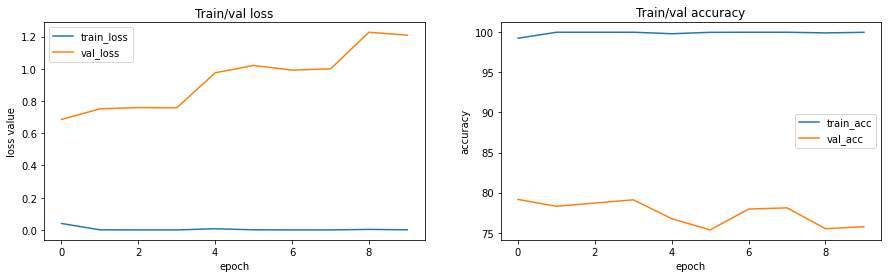

Best Epoch: 1 Average loss: 0.6859485534951091 Accuracy: 79.15
CPU times: user 1min 52s, sys: 17.9 s, total: 2min 10s
Wall time: 2min 10s


In [26]:
%%time
#Preparations
model = ClassifierNet()
model = model.to(device)
model.load_state_dict(get_transfer_model(net="RotPre").state_dict())

optimizer = optim.Adam(model.parameters(), lr=lr, betas=(beta1, 0.999))

fixed_features_results = fit("finetuned_features_rot", train_loader_2, val_loader, model, optimizer, loss_fn, n_epochs)
plot_results(fixed_features_results, train_loader_2, val_loader)

# Kaggle

In [42]:
model = ClassifierNet()
model = model.to(device)
model.load_state_dict(torch.load("fixed_features_rot.pht"))

<All keys matched successfully>

In [43]:
correct = 0
total = 0
total_loss = 0

criterion = nn.CrossEntropyLoss()

with torch.no_grad():
    for data in val_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
            
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        total_loss += loss.item()

print('Accuracy of the network on the 2000 validation images: %f %%' % (
    100 * correct / total))
print('Val loss', total_loss / len(val_loader))

Accuracy of the network on the 2000 validation images: 79.300000 %
Val loss 0.6912436140701175


We expect similar accuracy on the leaderboard. However, the overfitting is clear. Let us prepare the submission file.

In [ ]:
predictions = np.array([])

with torch.no_grad():
    for data in test_loader:
        inputs = data
        inputs = inputs.to(device)
        
        outputs = model(inputs)
            
        _, predicted = torch.max(outputs.data, 1)
        predictions = np.append(predictions, predicted.cpu())

In [ ]:
predictions = pd.DataFrame({
    "Id": np.arange(predictions.size),
    "Category": predictions},
    dtype=np.int64)

In [ ]:
predictions.to_csv("baseline_predictions.csv", index=False)